In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
from scipy.optimize import minimize 
from matplotlib.colors import ListedColormap

In [2]:
def process(f): 
    d = loadmat(f)['AngSpeed_OrientTIP']
    d[:, 1] = np.sin((d[:, 1]-90)/180*np.pi)
    return d 

## Read in data 

In [3]:
# Run this cell if we only look at the paired swimmers 

path = 'Data/SpinningRodOrientation/'
filenames = [f for f in os.listdir(path) if f.endswith('2.mat')] 
Ls = [int(f.split('_')[0][1:]) for f in filenames] 

## pair up the files 
data = [] 

for f in filenames: 
    p1 = process(path+f) 
    p2 = process(path+f[:-5]+'.mat')

    if len(p1) != len(p2):
        ll = max(len(p1), len(p2))
        if len(p1) < ll: 
            p1 = np.concatenate((p1, p2[len(p1):]))
        else: 
            p2 = np.concatenate((p2, p1[len(p2)-1:]))
    data.append((p1+p2)/2)

## Set up cmap, bins and define functions 

In [9]:
# Define a discrete colormap for the rods 

continuous_cmap = plt.get_cmap('plasma_r')
uni_Ls = sorted(np.unique(Ls))

colors = continuous_cmap(np.linspace(0.2, 1, len(uni_Ls)))
discrete_cmap = ListedColormap(colors)

colors = ["#FF0000", "#D95319", "#EDB120", "#77AC30", "#0072BD"]
markers = ['o', 's', 'd', '+', '*']

In [5]:
N = 19
bins = np.linspace(-0.85, 0.85, N+1)
mids = np.array([(x+y)/2 for (x, y) in zip(bins[:-1], bins[1:])])
mids_sym = mids[int((N)/2):]

guess = [10, 100]
bounds = [[0, None]]*2

def get_V(params, Ls): 
    V = ( 0.5*np.outer(4 - params[0]/Ls, mids_sym**2) +  
             0.25*params[1]*(mids_sym**4)[np.newaxis, :])
    Z = np.sum(np.exp(-V), axis=-1)*(mids_sym[1]-mids_sym[0])
    V += np.log(Z)[:, np.newaxis]
    return V 

def cost(params, Ls, Ps): 
    # quadratic cost function
    # params in order of gamma, a, b 
    V_fit = get_V(params, Ls)
    return np.sum(V_fit*Ps)

def count_Ps(data, Ls):
    Ps = [] 
    uni_Ls = sorted(np.unique(Ls))
    for L in uni_Ls: 
        single_length = np.concatenate([d for (d, l) in zip(data, Ls) if l == L]) 
        counts, _ = np.histogram(single_length[:, 1], bins=bins, density=True)
        Ps.append(counts)
    return np.array(Ps), uni_Ls 

def extract_xy(data, Ls): 
    uni_Ls = sorted(np.unique(Ls))
    x = [] 
    y = [] 
    for L in uni_Ls: 
        single_length = np.concatenate([d for (d, l) in zip(data, Ls) if l == L])
        x.extend(single_length[:, 1]) 
        y.extend(single_length[:, 0]*L*L)
    return x, y  

## Bootstrap to generate more sample sets

In [7]:
MAPs = [] 
index_array = np.arange(len(data))

for j in range(100):
    ind = np.random.choice(index_array, len(data))
    resampled_data = [data[index] for index in ind]
    resampled_Ls = [Ls[index] for index in ind]
    Ps, uni_Ls = count_Ps(resampled_data, resampled_Ls)
    Ps_sym = Ps[:, int((N)/2):] + np.flip(Ps[:, :int((N)/2)+1], axis=1)

    f = lambda x: cost(x, uni_Ls, Ps_sym) 
    res = minimize(f, guess, bounds=bounds, method='trust-constr')
    MAPs.append(res.x)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [8]:
mean = np.mean(MAPs, axis=0)
cov = np.cov(np.transpose(MAPs))
print(mean, cov, np.sqrt(np.diag(cov)))


[84.90120685 60.0112442 ] [[289.48896709 149.86559272]
 [149.86559272 115.32216021]] [17.01437531 10.73881559]


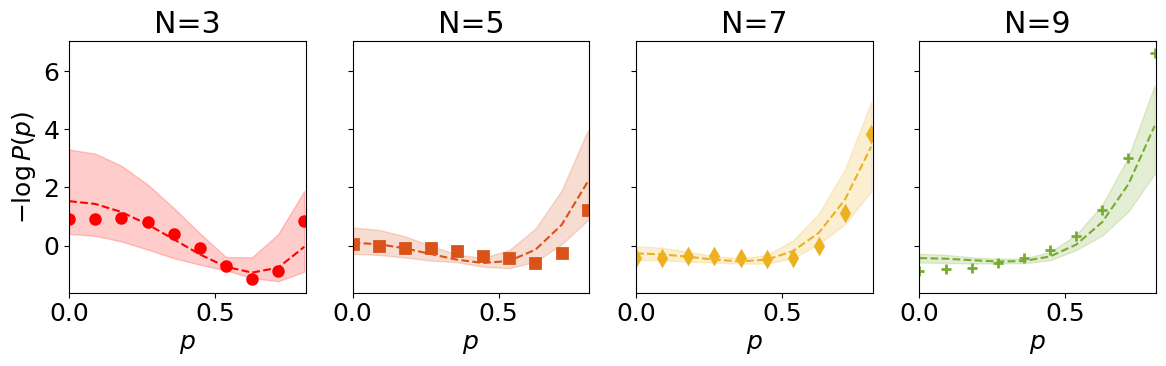

In [9]:
Ps, uni_Ls = count_Ps(data, Ls)
Ps_sym = Ps[:, int((N)/2):] + np.flip(Ps[:, :int((N)/2)+1], axis=1)

V_fit1 = get_V(mean, uni_Ls)



num_samples = 50 
samples = np.random.multivariate_normal(mean, cov, num_samples)
V_fits = [get_V(s, uni_Ls) for s in samples]
V_fit2 = np.min(V_fits, axis=0)
V_fit3  = np.max(V_fits, axis=0)

plt.rc('text', usetex=False)
plt.rc('font', family='sans serif', size=18)

fig, axes = plt.subplots(1, len(uni_Ls)-2, sharex=True, sharey=True, figsize=(12, 4))

for (i, L) in enumerate(uni_Ls): 
    if L <= 9: 
        axes[i].plot(mids_sym, -np.log(Ps_sym[i]), marker=markers[i], linestyle='None', markeredgewidth=2, markersize=7, c=colors[i])
        axes[i].plot(mids_sym, V_fit1[i], '--', c=colors[i])
        axes[i].fill_between(mids_sym, V_fit2[i], V_fit3[i], color=colors[i], alpha=0.2)
        axes[i].set_title('N={}'.format(L))
        axes[i].set_xlabel(r'$p$')
axes[0].set_ylabel(r'$-\log P(p)$')
axes[0].set_xlim([0, 0.81])
plt.tight_layout()
plt.savefig('Figures/sr_fit.pdf')
plt.show()

## Diagram for pitchfork bifurcation as N decreases 

In [10]:
uni_Ls.remove(10)
agg_data = [np.concatenate([d[:, 1] for (d, l) in zip(data, Ls) if l == L])for L in uni_Ls]

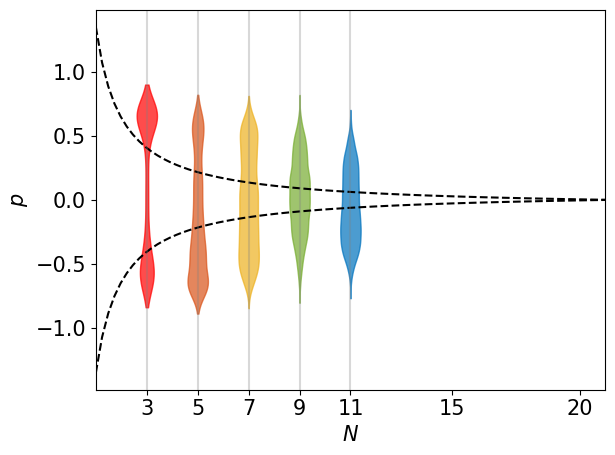

In [23]:
L_continous = np.linspace(1, 25, 100)
a = 0.5*(4 - mean[0]/L_continous)
b = 0.25*mean[1]

minima = -a/(2*b)
minima = np.where(minima < 0, 0, minima)
plt.plot(L_continous, minima, 'k--', label='minima')
plt.plot(L_continous, -minima, 'k--')

violin_parts = plt.violinplot(agg_data, uni_Ls, showmeans=False, showmedians=False, showextrema=True, widths=0.8)

plt.rc('text', usetex=False)
plt.rc('font', family='sans serif', size=15)

for partname in ('cmins', 'cmaxes'):
    vp = violin_parts[partname]
    vp.set_linewidth(0)

violin_parts['cbars'].set_linewidth(0)
violin_parts['cbars'].set_edgecolor('gray')


for i, body in enumerate(violin_parts['bodies']): 
    body.set_facecolor(colors[i])
    body.set_edgecolor(colors[i])  # Set edge color
    body.set_alpha(0.7)  # Set transparency


for L in uni_Ls: 
    plt.axvline(x=L, c='gray', linestyle='-', alpha=0.3)

plt.xlabel(r'$N$')
plt.xticks([0, 3, 5, 7, 9, 11, 15, 20])
plt.ylabel(r'$p$')
plt.xlim([1, 21])
plt.tight_layout()
plt.savefig('Figures/sr_violin.pdf')
plt.show() 



## Linear regression fit to relate theta and p 

In [6]:
fits = [] 
index_array = np.arange(len(data))
for j in range(100):
    ind = np.random.choice(index_array, len(data))
    resampled_data = [data[index] for index in ind]
    resampled_Ls = [Ls[index] for index in ind]

    x, y = extract_xy(resampled_data, resampled_Ls)
    m, b = np.polyfit(x, y, 1)
    fits.append([m, b])

In [7]:
mean = np.mean(fits, axis=0)
cov = np.cov(np.transpose(fits))
print(mean, cov, np.sqrt(np.diag(cov)))

[55.1795671  -0.18954944] [[11.59800914 -0.29727434]
 [-0.29727434  1.04050749]] [3.40558499 1.02005269]


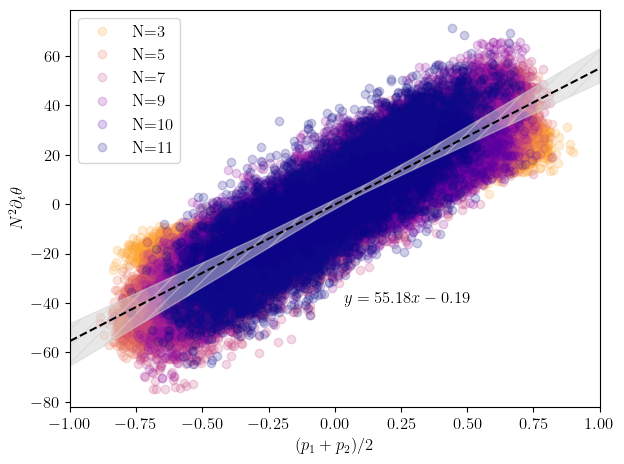

In [11]:

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

uni_Ls = sorted(np.unique(Ls))

for (i, L) in enumerate(uni_Ls): 
    d = np.concatenate([d for (d, l) in zip(data, Ls) if l == L])
    plt.plot(d[:, 1], d[:, 0]*L*L, 'o', alpha=0.2, c=discrete_cmap(i), label='N={}'.format(L))
plt.legend()
plt.ylabel(r'$  N^2   \partial_t \theta$')
plt.xlabel('$(p_1 + p_2)/2$')

X = np.linspace(-1, 1, 100)
Y1 = mean[0]*X+mean[1]
num_samples = 50 
samples = np.random.multivariate_normal(mean, cov, num_samples)
Ys = [s[0]*X+s[1] for s in samples]
Y2 = np.min(Ys, axis=0)
Y3  = np.max(Ys, axis=0)

plt.plot(X, Y1, '--k', zorder=3)

plt.fill_between(X, Y2, Y3, color='lightgray', zorder=2, alpha=0.5, hatch='//')
plt.xlim([-1, 1])
plt.figtext(0.55, 0.35, r'$y = {:.2f}x {:.2f}$'.format(mean[0], mean[1]))
plt.tight_layout()
plt.savefig('Figures/sr_1.png')
plt.show() 